In [38]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [39]:
with sqlite3.connect("../db.sqlite3") as conn:
    db_df = pd.read_sql(
        """
        select rp.id, rp.name, rp.price, ro.quantity, r.datetime from restaurant_product rp
        join main.restaurant_orderitem ro on rp.id = ro.product_id
        join main.restaurant_order r on r.id = ro.order_id;
        """,
        conn
    )
    db_df["datetime"] = pd.to_datetime(db_df["datetime"])
    db_df.to_csv("products.csv", index=False)

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

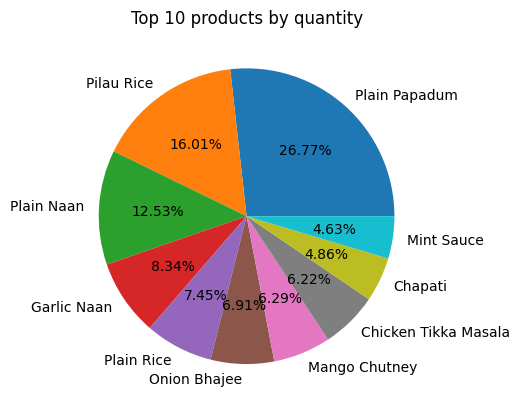

In [40]:
grouped = db_df.groupby("name")["quantity"].sum()
sorted_groups= grouped.sort_values(ascending=False)[:10]

sorted_groups.plot(kind="pie", autopct="%.2f%%")
plt.title("Top 10 products by quantity")
plt.ylabel('')
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

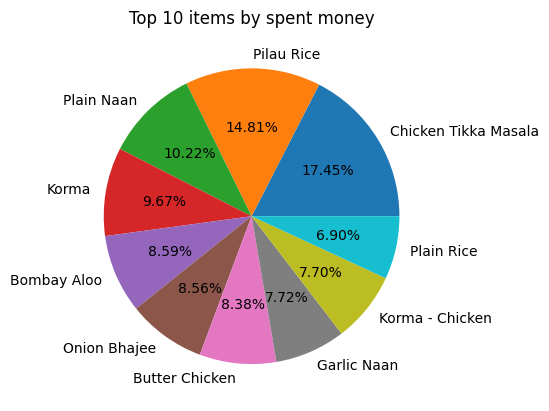

In [41]:
db_df["item_price"] = db_df["price"] * db_df["quantity"]
grouped = db_df.groupby("name")["item_price"].sum()
sorted_groups = grouped.sort_values(ascending=False)[:10]

sorted_groups.plot(kind="pie", autopct="%.2f%%")
plt.title("Top 10 items by spent money")
plt.ylabel('')
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

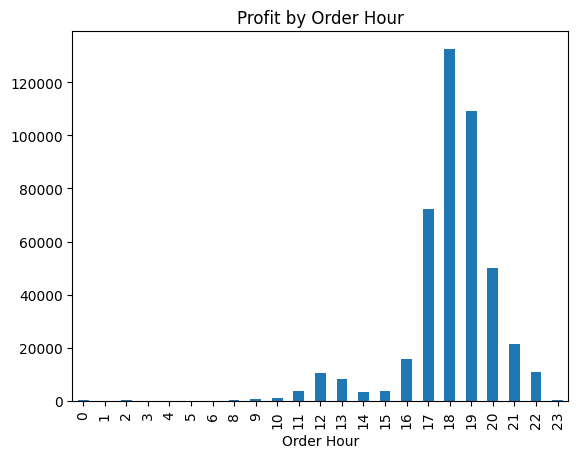

In [42]:
db_df["order_hour"] = db_df["datetime"].dt.hour
grouped = db_df.groupby("order_hour")["item_price"].sum()

grouped.plot(kind="bar")
plt.title("Profit by Order Hour")
plt.xlabel("Order Hour")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

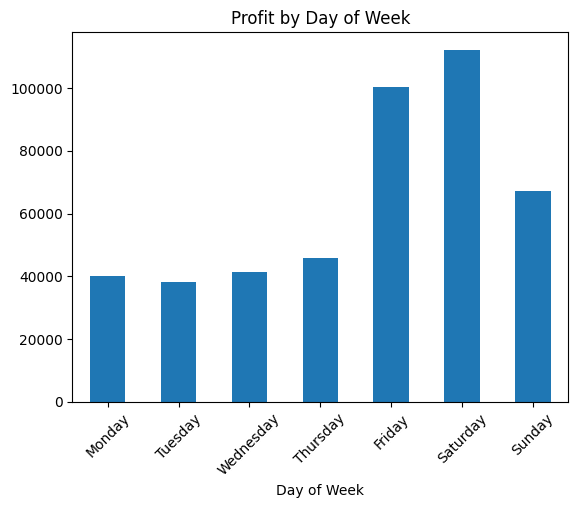

In [43]:
db_df["order_day_of_week"] = db_df["datetime"].dt.day_name()
grouped = db_df.groupby([db_df["datetime"].dt.day_of_week, "order_day_of_week"])["item_price"].sum()
grouped = grouped.droplevel("datetime")

grouped.plot(kind="bar")
plt.title("Profit by Day of Week")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.show()